In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time
import random
import pickle

In [2]:
NAME = "Chest-Xray-Pneumonia-cnn-64x2-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [3]:
DATADIR = "data/data/train"
DATADIRTEST = "data/data/test"
DATADIRVAL = "data/data/val/"

CATEGORIES = ['NORMAL','PNEUMONIA']
IMG_SIZE = 150

def create_data(directory):
    data = []
    X = []
    y= []
    random.seed(42)
    for category in CATEGORIES:
        path = os.path.join(directory, category) # path to normal and pneumonia dir
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                data.append([new_array,class_num])
            except Exception as e:
                pass
    random.shuffle(data)
    for features, label in data:
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
    y = np.array(y)
    return X,y
            
X_train,y_train = create_data(DATADIR)

X_val,y_val = create_data(DATADIRVAL)

X_test,y_test = create_data(DATADIRTEST)

In [4]:
# i will try to balance the distribution in validation dataset 

# check distribution of y in test and train set
train_dist = np.sum(y_train) / len(y_train) * 100
val_dist = np.sum(y_val) / len(y_val) * 100
test_dist = np.sum(y_test) / len(y_test) * 100
print("Train pneumonia dist: {}".format(train_dist))
print("Val pneumonia dist: {}".format(val_dist))
print("Test pneumonia dist: {}".format(test_dist))

Train pneumonia dist: 74.29064417177914
Val pneumonia dist: 50.0
Test pneumonia dist: 62.5


In [14]:
X_train = X_train / 255.0 # normalize data dividing by maximum (in this case we`re working with images so minimum and max are 0 and 255)
X_val = X_val / 255
X_test = X_test / 255

# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

model = Sequential()
#input layer
model.add(Conv2D(32,(3,3),padding='same',strides=1, activation='relu',input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2),strides=2, padding='same'))

#layer
model.add(Conv2D(64,(3,3),padding='same',strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = (2,2),strides=2, padding='same'))

#layer
model.add(Conv2D(128,(3,3),padding='same',strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = (2,2),strides=2, padding='same'))

#layer
model.add(Conv2D(256,(3,3),padding='same',strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = (2,2),strides=2, padding='same'))

model.add(Flatten())

#layer
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

#output layer
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(datagen.flow(X_train,y_train,batch_size=16),steps_per_epoch=len(X_train)/16,epochs=10,validation_data=datagen.flow(X_val,y_val),callbacks=[tensorboard,learning_rate_reduction])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 64)       

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


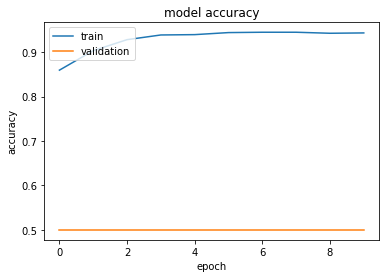

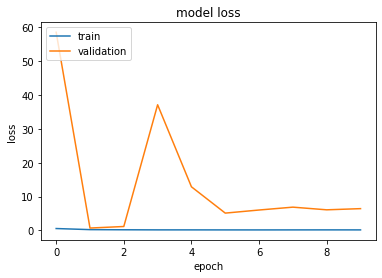

In [17]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
# test model with validation images
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
20/20 [==============================] - 3s 144ms/step - loss: 0.6380 - accuracy: 0.8958
test loss, test acc: [0.6380187273025513, 0.8958333134651184]


In [13]:
model.save('BESTMODEL')

INFO:tensorflow:Assets written to: BESTMODEL\assets


array([[0.]], dtype=float32)

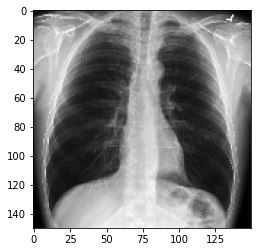

In [9]:
img_array = cv2.imread('lung.jpg',cv2.IMREAD_GRAYSCALE)
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap='gray')
n = np.array(new_array).reshape(-1,IMG_SIZE,IMG_SIZE,1)
model.predict(n)

array([[0.]], dtype=float32)

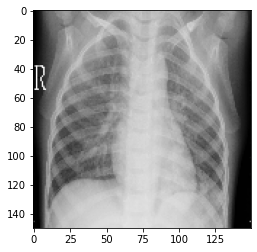

In [19]:
# test with pneumonia image xray
img_array = cv2.imread('data/data/val/PNEUMONIA/person1950_bacteria_4881.jpeg',cv2.IMREAD_GRAYSCALE)
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap='gray')
n = np.array(new_array).reshape(-1,IMG_SIZE,IMG_SIZE,1)
model.predict(n)